In [18]:
import turtlebot4_wrapper

turtlebot4_wrapper.use_hardware()
# turtlebot4_wrapper.use_simulation()

# load ROS library
import rclpy
if not rclpy.ok():
    rclpy.init()

# Instantiate Wrapper. The subscribes and publishes the relevant topics and connects the actions.
if not "robot" in globals():
    robot = turtlebot4_wrapper.Robot()

You are connected to uwbot-02
Robot is reachable
ros2 topic echo --once /ip failed. Proceed with caution.
ros2 topic subscription working. Everything is working as expected.


Could not determine the type for the passed topic


In [64]:
# Make sure we have fresh data by waiting for a new message
robot.reset_odometry()
robot.battery_state_future = rclpy.Future()
robot.spin_until_future_completed(robot.battery_state_future)

# Pretty print the contents of the message
print("Battery {0:2.3}%, charging with {1:2.2}A".format(
    robot.last_battery_state_msg.percentage*100,
    robot.last_battery_state_msg.current
))

Battery 40.0%, charging with -1.1A


(-3.0, 3.0)

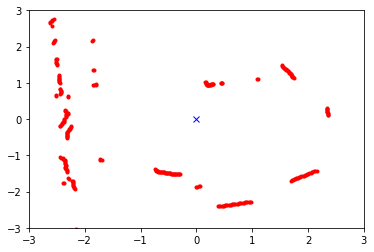

In [65]:
from matplotlib import pyplot as plt
import numpy as np
# Plot robot position from odometry
# Use blue cross marker to designate the robot position

robot.scan_future = rclpy.Future()
robot.odom_future = rclpy.Future()
robot.spin_until_future_completed(robot.scan_future);
robot.spin_until_future_completed(robot.odom_future);
pose = robot.last_odom_msg.pose.pose

T_base_lidar = np.array([[ 2.22044605e-16, -1.00000000e+00, -4.00000000e-02],
       [ 1.00000000e+00,  2.22044605e-16,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])


# print(robot.last_scan_msg)
# print(robot.last_odom_msg)
# print(robot.reduce_transform_to_2D(robot.get_tf_transform("base_link","rplidar_link")))
def get_distance(x1 , y1 , x2 ,y2):
    return np.sqrt((x2-x1)**2+(y2-y1)**2)

def is_not_rods(pt , x2 ,y2):
    if get_distance(pt[0] ,pt[1] , x2, y2) >= 0.14:
        return True
    else:
        return False

# T_base_lidar = robot.reduce_transform_to_2D(robot.get_tf_transform("base_link","rplidar_link"))

# Plot lidar points from last message
def plot_lidar_scan_points_working(msg,pose):
    # Convert received lidar points into cartesian coordinates considering the current position from odometry
    import numpy
    points = [(numpy.cos(angle)*radius,numpy.sin(angle)*radius) for angle, radius \
              in zip(numpy.linspace(msg.angle_min,msg.angle_max,len(msg.ranges)),msg.ranges)]
    # print(points[0:5])

    T = robot.reduce_transform_to_2D(robot.convert_odom_to_transform(pose))
    # print(T)
    
    # remove points which cannot be measured
    filtered_points = filter(lambda x: numpy.isfinite(x).all(),points)

    
    # display points in world frame
    transformed_points = [numpy.matmul(np.dot(T,T_base_lidar),
        numpy.vstack([ numpy.atleast_2d(x).T,numpy.ones((1,1)) ]) ) for x in 
                          filtered_points]
    
    # transformed_points = [pnt for pnt in transformed_points if abs(pnt[0]) <= 3 and abs(pnt[1]) <= 3]           
    # # transformed_points = [pnt for pnt in transformed_points if abs(pnt[0]) >= 0.0 and abs(pnt[1]) >= 0.095]  
    transformed_points = [pnt for pnt in transformed_points if is_not_rods(pnt , pose.position.x , pose.position.y )] 

    return transformed_points
    
    

transformed_points = plot_lidar_scan_points_working(robot.last_scan_msg,pose)
plt.plot([pose.position.x],[pose.position.y],'bx') # TODO: show robot front
plt.plot(
    [x[0] for x in transformed_points],
    [x[1] for x in transformed_points],'r.')
plt.ylim(-3.,3.)
plt.xlim(-3.,3.)


In [ ]:
robot.dock()

In [62]:
import numpy as np
import numpy as np
from tf_transformations import euler_from_quaternion
from geometry_msgs.msg import Twist

def grad_to_vel(dx,dy):
    while True:
        # Localization
        robot.scan_future = rclpy.Future()
        robot.odom_future = rclpy.Future()
        robot.spin_until_future_completed(robot.scan_future)
        robot.spin_until_future_completed(robot.odom_future)
        pose = robot.spin_until_future_completed(robot.odom_future).pose.pose
        # (currentx, currenty) = (pose.position.x, pose.position.y)
        yaw = np.arctan2(2 * (pose.orientation.w * pose.orientation.z + pose.orientation.x * pose.orientation.y),1 - 2 * (pose.orientation.y ** 2 + pose.orientation.z ** 2))

        # Navigation
        distance = np.sqrt((np.square(dx))+(np.square(dy)))
        angle_goal = np.arctan2((dy),(dx))
        angle_diff_rad = np.arctan2(np.sin(angle_goal-yaw), np.cos(angle_goal-yaw))
        vel_dir =  1*angle_diff_rad
        # print(angle_diff_rad)
        # print("x_pos" , currentx , "y_pos" , currenty ,"dist",distance,"angle",yaw,"angle_goal",angle_goal,end="\r")
        msg = Twist()
        
        if abs(angle_diff_rad) > 0.03:
            msg.linear.x = 0. #min(0.02, 1. * distance)
            msg.angular.z = max(-0.4,min(0.4, 0.25 * (vel_dir)))
            robot.cmd_vel_publisher.publish(msg)
        else:
            break
        # print("x_pos" , currentx , "y_pos" , currenty ,"dist",distance,"angle",yaw,"angle_goal",angle_goal,end="\r")
      
    distance = np.sqrt((np.square(dx))+(np.square(dy)))
    msg.linear.x = max(0.17 , 0.1*distance)
    msg.angular.z = 0. #max(-0.1,min(0.1, 0.25 * (desired_yaw-yaw)))
    robot.cmd_vel_publisher.publish(msg)
        # if(distance<0.07):
        #     return

def grad_to_vel_v2(dx,dy):
    while True:
        # Localization
        robot.scan_future = rclpy.Future()
        robot.odom_future = rclpy.Future()
        robot.spin_until_future_completed(robot.scan_future)
        robot.spin_until_future_completed(robot.odom_future)
        pose = robot.spin_until_future_completed(robot.odom_future).pose.pose
        # (currentx, currenty) = (pose.position.x, pose.position.y)
        yaw = np.arctan2(2 * (pose.orientation.w * pose.orientation.z + pose.orientation.x * pose.orientation.y),1 - 2 * (pose.orientation.y ** 2 + pose.orientation.z ** 2))

        # Navigation
        distance = np.sqrt((np.square(dx))+(np.square(dy)))
        angle_goal = np.arctan2((dy),(dx))
        angle_diff_rad = np.arctan2(np.sin(angle_goal-yaw), np.cos(angle_goal-yaw))
        vel_dir =  1*angle_diff_rad
        # print(angle_diff_rad)
        # print("x_pos" , currentx , "y_pos" , currenty ,"dist",distance,"angle",yaw,"angle_goal",angle_goal,end="\r")
        msg = Twist()
        
        if abs(angle_diff_rad) > 0.03:
            msg.linear.x = 0.3
            msg.angular.z = max(-0.4,min(0.4, 0.25 * (vel_dir)))
            robot.cmd_vel_publisher.publish(msg)
        else:
            msg.linear.x = 0.3
            msg.angular.z = 0.
            robot.cmd_vel_publisher.publish(msg)
            return

def get_distance(x1 , y1 , x2 ,y2):
    return np.sqrt((x2-x1)**2+(y2-y1)**2)
        

        



In [66]:
goal = (3,0)

dist_to_goal = get_distance(0 , 0 , goal[0] ,goal[1])

while (dist_to_goal >= 0.1):
    ox ,oy ,gx ,gy ,dx ,dy = 0,0,0,0,0,0
    robot.scan_future = rclpy.Future()
    robot.odom_future = rclpy.Future()
    robot.spin_until_future_completed(robot.scan_future)
    odom = robot.spin_until_future_completed(robot.odom_future)
    pose = odom.pose.pose
    (currentx, currenty) = (pose.position.x, pose.position.y)
    gx = goal[0] - currentx
    gy = goal[1] - currenty

    dx = gx+ox
    dy = gy+oy

    obstacles = plot_lidar_scan_points_working(robot.last_scan_msg,pose)
    for ob in obstacles:
        # dist = get_distance(currentx , currenty , ob[0] ,ob[1])
        # if (dist <=  0.50):
        #     print("within dist " , dist)
        #     print("current = " , currentx , currenty , "obs = " ,ob)
        #     oy -= 0.5 - (ob[1] - currenty)
        #     ox -= 0.5 - (ob[0] - currentx)

        if (abs(currentx - ob[0]) <=  0.50):
            dy -= 0.5
            dx = currentx
            break
        elif (abs(currentx - ob[1]) <=  0.50):
            dx -= 0.5
            dy = currenty
            break
            
            



    grad_to_vel(float(dx) , float(dy))
    dist_to_goal = get_distance(currentx , currenty , goal[0] ,goal[1])
    print(dist_to_goal , end = '\r')

    



KeyboardInterrupt: 

In [ ]:
robot.odom_future = rclpy.Future()
pose = robot.spin_until_future_completed(robot.odom_future).pose.pose
(currentx, currenty) = (-pose.position.x, -pose.position.y)

goal = (5,5)
dx = goal[0] - currentx
dy = goal[1] - currenty
grad_to_vel(dx , dy)


# grad_to_vel(0,1)
